# 한글 폰트 사용 라이브러리

In [1]:
!pip install eli5==0.13.0
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


필요 추가 라이브러리

In [15]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

# 데이터 로드

In [7]:
train_path = '/data/ephemeral/home/train.csv'
test_path  = '/data/ephemeral/home/test.csv'
subway_path = '/data/ephemeral/home/subway_feature.csv'
bus_path = '/data/ephemeral/home/bus_feature.csv'
sub_path = '/data/ephemeral/home/realprice_file.csv'
sub_data = pd.read_csv(sub_path)
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
subway = pd.read_csv(subway_path)
bus = pd.read_csv(bus_path)

In [10]:
# Train data와 Test data shape은 아래와 같습니다.
print(df_train.shape, df_test.shape, subway.shape, bus.shape, sub_data.shape)

(1118822, 52) (9272, 51) (768, 5) (12584, 6) (121, 2)


In [9]:
# 서울특별시 아파트 실거래가지수(2013.11~2023.11)
# https://www.reb.or.kr/r-one/cm/cntnts/cntntsView.do?mi=10116&cntntsId=1407 <- 최근 10년치
# (2006년 기준 = 100)
sub_data

,계약년월,실거래지수
0,201311,74.5
1,201312,74.3
2,201401,75.0
3,201402,75.6
4,201403,76.0
...,...,...
116,202307,157.9
117,202308,159.8
118,202309,161.4
119,202310,161.2


In [11]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
df_train['is_test'] = 0
df_test['is_test'] = 1
concat = pd.concat([df_train, df_test])     # 하나의 데이터로 만들어줍니다.

In [12]:
concat['is_test'].value_counts()

0    1118822
1       9272
Name: is_test, dtype: int64

In [13]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

# column 살펴보기

In [14]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test'],
      dtype='object')

In [ ]:
# 범주형 변수와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='범주형 변수', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('범주형 변수별 target 분포')
plt.show()

In [ ]:
# 수치형 변수와 target과의 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='수치형 변수', y='target', data=concat)
plt.title('수치형 변수와 target 간의 관계')
plt.show()

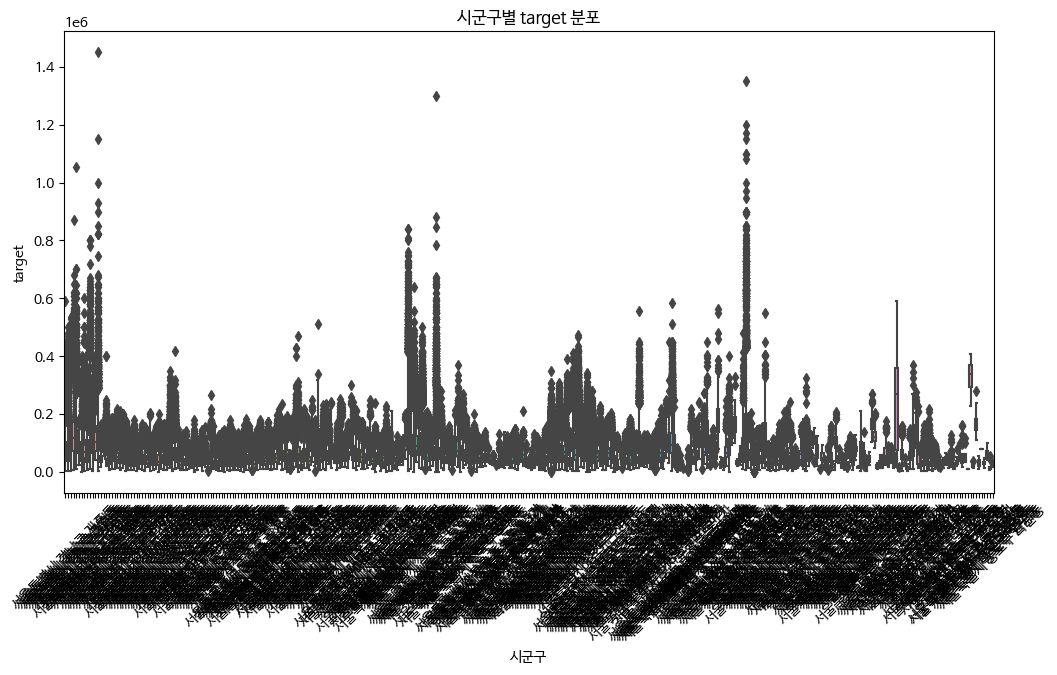

In [16]:
# 시군구와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='시군구', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('시군구별 target 분포')
plt.show()

In [17]:
# '시군구'별 'target'의 평균 계산
average_target_by_gu = concat.groupby('시군구')['target'].mean()
sorted_average_target = average_target_by_gu.sort_values(ascending=False)
print(sorted_average_target)

시군구
서울특별시 종로구 신문로2가      329833.333333
서울특별시 중구 장충동1가       255131.818182
서울특별시 강남구 압구정동       203222.949968
서울특별시 용산구 용산동5가      188139.910569
서울특별시 종로구 홍파동        170336.419753
                         ...      
서울특별시 영등포구 영등포동4가     13926.136364
서울특별시 서대문구 미근동        13084.848485
서울특별시 영등포구 영등포동3가     11530.827068
서울특별시 성북구 안암동5가       11300.000000
서울특별시 중구 장충동2가         8530.128205
Name: target, Length: 339, dtype: float64


In [18]:
# '시군구'별 'target'의 최대 계산
max_target_by_gu = concat.groupby('시군구')['target'].max()
sorted_max_target = max_target_by_gu.sort_values(ascending=False)
print(sorted_max_target)

시군구
서울특별시 강남구 청담동        1450000.0
서울특별시 용산구 한남동        1350000.0
서울특별시 성동구 성수동1가      1300000.0
서울특별시 강남구 삼성동        1053000.0
서울특별시 강남구 도곡동         870000.0
                       ...    
서울특별시 종로구 누상동          19000.0
서울특별시 영등포구 당산동6가       17900.0
서울특별시 영등포구 영등포동4가      16500.0
서울특별시 영등포구 영등포동3가      13500.0
서울특별시 성북구 안암동5가        11300.0
Name: target, Length: 339, dtype: float64


In [19]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat['구'] = concat['시군구'].map(lambda x : x.split()[1])
concat['동'] = concat['시군구'].map(lambda x : x.split()[2])

In [20]:
# '시군구'별 'target'의 평균 계산
average_target_by_gu = concat.groupby('구')['target'].mean()
sorted_average_target = average_target_by_gu.sort_values(ascending=False)
print(sorted_average_target)

구
강남구     114847.461503
서초구     113608.653390
용산구     105876.961900
송파구      83868.032920
성동구      68924.389400
광진구      67158.379293
마포구      64445.226137
중구       62084.985733
동작구      60936.451058
양천구      59042.132927
종로구      57674.032963
영등포구     56137.342464
강동구      54402.872801
서대문구     49082.573688
동대문구     45194.761822
성북구      45117.779038
강서구      44215.453701
은평구      43721.691848
관악구      41954.133039
구로구      38605.012447
강북구      38316.975201
중랑구      35195.762819
노원구      33870.444730
금천구      33709.248647
도봉구      31924.613711
Name: target, dtype: float64


# 강남지역의 집값의 평균과 최고가는 최고이지만 동 단위에서는 그렇지 못한 모습을 보이고 강남 외 구 단위에 대해서도 지역단위의 일관성을 가지는 모습은 아니라고 판단하여 지역에 관한 변수들은 column select에서 우선 drop 후 진행
- 시군구, 번지, 본번, 부번

# 지역 관련은 관계없지만 각 건물에 따른 차이는 시각화는 어렵지만 유의미한 것으로  임의 판단(살리기)
- 아파트명, 도로명, k-전화번호, k-팩스번호, k-홈페이지, 단지신청일,k-등록일자, 단지소개기존clob, 단지승인일, k-사용검사일-사용승인일, k-연면적, k-주거전용면적, k-관리비부과면적, k-수정일자, 고용보험관리번호, 건축면적

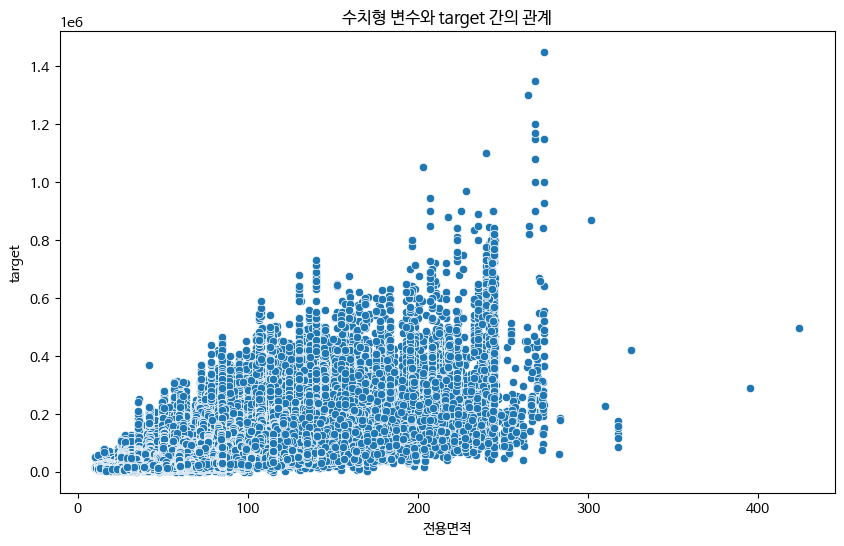

In [21]:
# 전용면적과 target과의 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='전용면적', y='target', data=concat)
plt.title('수치형 변수와 target 간의 관계')
plt.show()

In [23]:
correlation_m2 = concat['전용면적'].corr(concat['target'])
correlation_m2

0.5770410539849902

# 전용면적과 target과의 상관관계를 있는 것으로 판단
- 전용면적 save

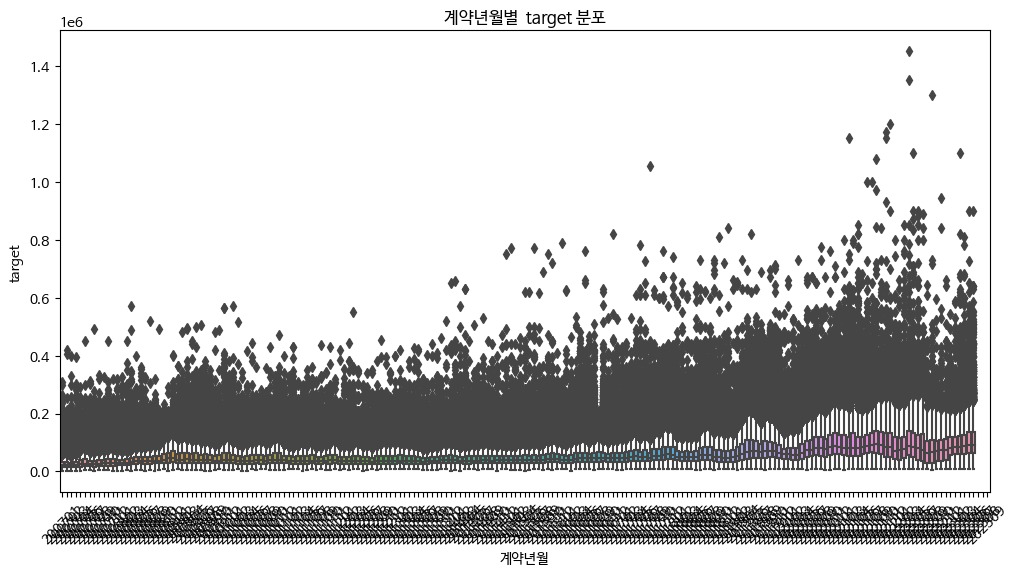

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='계약년월', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('계약년월별  target 분포')
plt.show()

In [26]:
correlation_month = concat['계약년월'].corr(concat['target'])
correlation_month

0.3446651444194359

![](/data/ephemeral/home/근거1.png)

# 시간의 흐름에 따라 평균 실거래가가 오르는 것으로 판단
- 물가? ---- 차후에 생각해보니 int형이라 물가와 크게 상관 없음을 판단
- 월 단위 시간에 따라 실거래가가 오른 것은 확인 가능

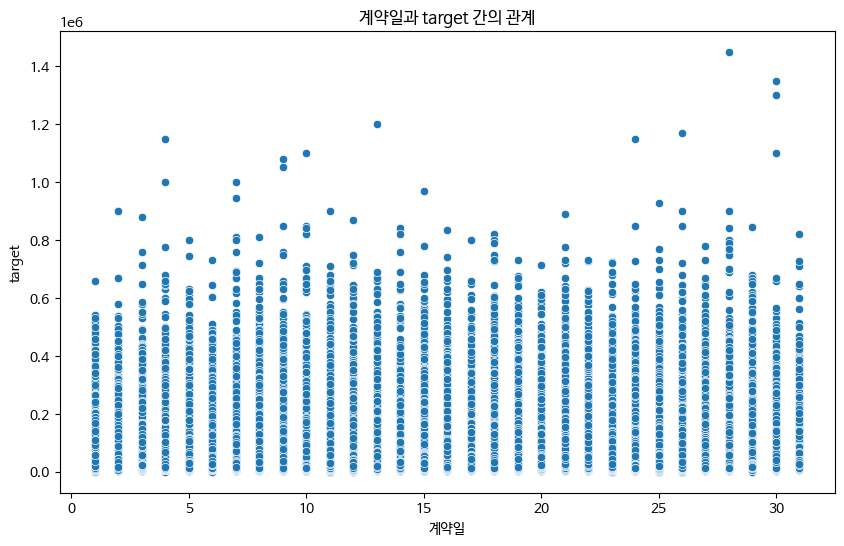

In [29]:
# 계약일과 target과의 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='계약일', y='target', data=concat)
plt.title('계약일과 target 간의 관계')
plt.show()

In [30]:
correlation_day = concat['계약일'].corr(concat['target'])
correlation_day

0.009348037386029545

# 계약일과의 관계는 없는 것으로 판단하여 drop

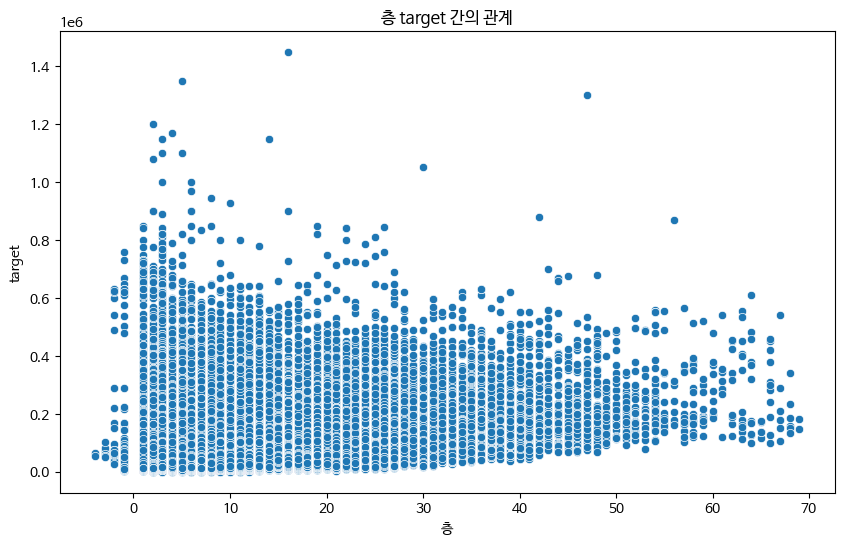

In [31]:
# 층과 target과의 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='층', y='target', data=concat)
plt.title('층 target 간의 관계')
plt.show()

In [32]:
correlation_floor = concat['층'].corr(concat['target'])
correlation_floor

0.15317571715385123

# 층과의 관계는 상관관계도 낮고 시각적으로 보았을 때 고층일수록 저점은 높지만 고점이 다름
- 최대 층 대비 몇퍼센트의 층? 지역 및 주변 상황에 따라 선호 층수에 대한 고려할 점이 너무 많음
- 채택하지 않고 drop

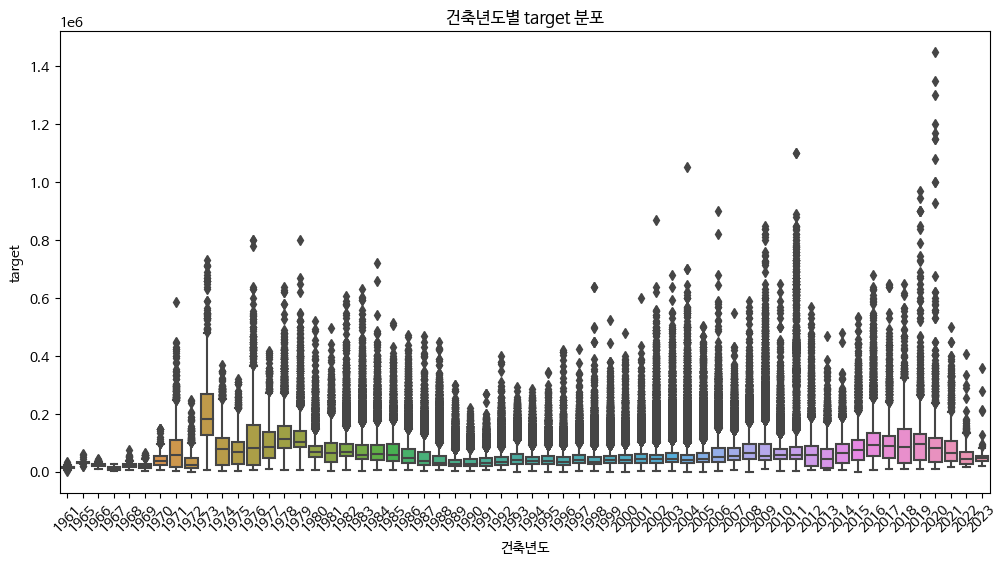

In [33]:
# 건축년도와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='건축년도', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('건축년도별 target 분포')
plt.show()

# 1990년도 근처의 시점에서 전체적인 감소폭이 보임 
- 충분한 상관관계가 있어 보임
- 추가 수집 데이터가 2013년부터여서 그 이후로는 선형 증가
- 채택

# 해제사유발생일
- 거래 해제시 해제한 사유 발생일 
- 실제로 거래되지 않은 거래
- 수치 존재 여부로 1,0을 가지는 새 파생변수 생성 후 사용or 존재하는 변수 제거, 원본 데이터는 학습시 우선 drop -> 베이스라인 코드에서 결측치 비율이 높아 제거시에도 학습시 향상이 된다 판단

# 등기신청일
- 증여 및 개인간 직거래로 판단
- 결측치가 높아 해제사유발생일과 같이 여부로 drop 고민

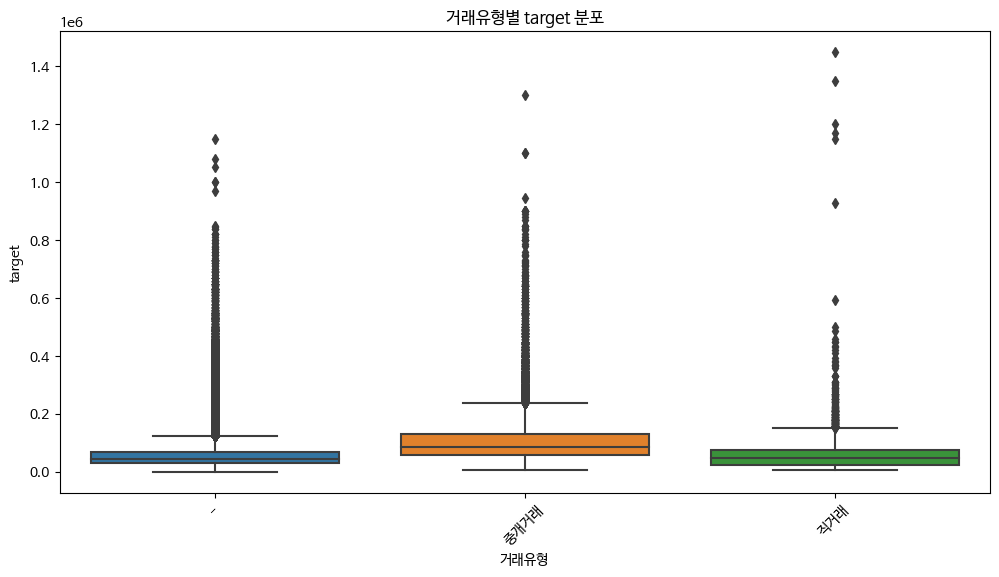

In [36]:
# 거래유형과 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='거래유형', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('거래유형별 target 분포')
plt.show()

In [37]:
method_name = '거래유형'
value_counts_method = concat[method_name].value_counts()

# 결과 출력
print(value_counts_method)

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64


# 결측치가 높고 직거래 비율이 너무 낮아서 drop
# 중개거래 수치도 얼마 되지 않고 그에따른 중개사 소재지는 불필요하다고 판단하여 drop

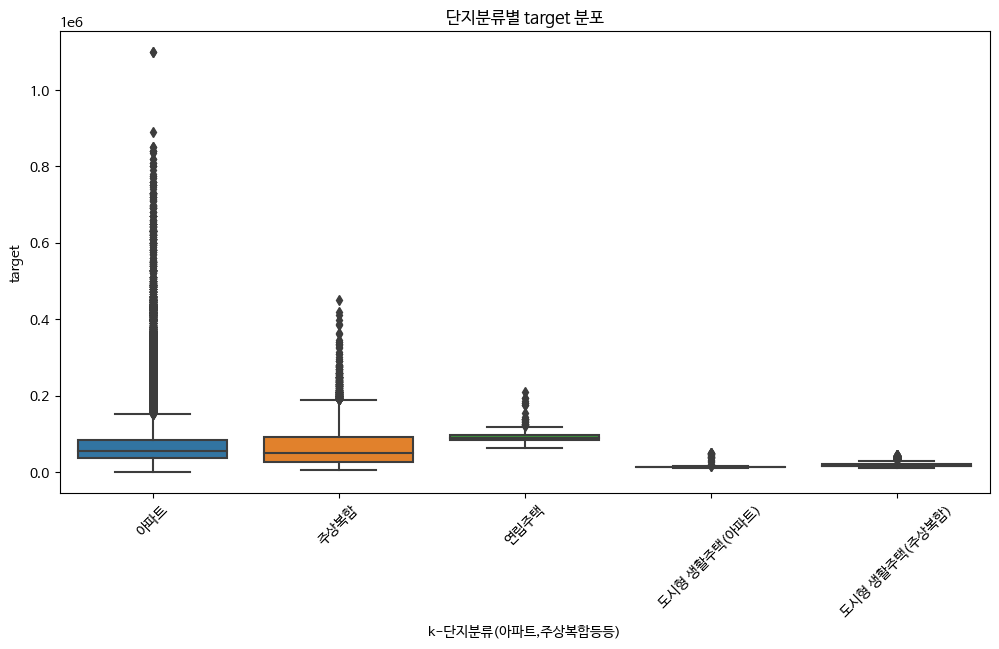

In [38]:
# k-단지분류(아파트,주상복합등등)와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='k-단지분류(아파트,주상복합등등)', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('단지분류별 target 분포')
plt.show()

# 건물별로 구별을 하기로 하였으면 단지분류가 중요할까? 도시형 주거종이 평균가가 낮다는 점을 제외하면 딱히 인사이트를 얻기 힘들다 drop

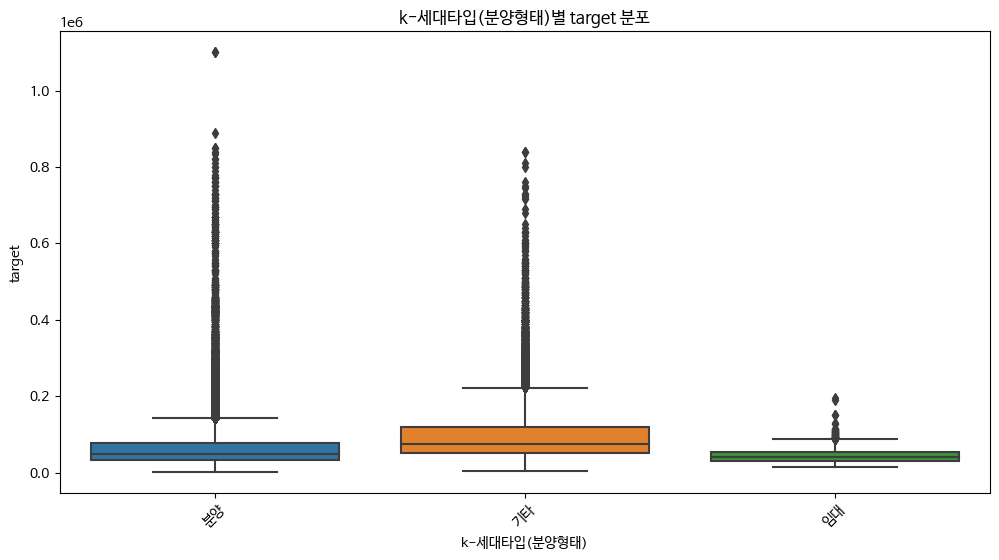

In [39]:
# k-세대타입(분양형태)와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='k-세대타입(분양형태)', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('k-세대타입(분양형태)별 target 분포')
plt.show()

In [40]:
type_name = 'k-세대타입(분양형태)'
value_counts_type = concat[type_name].value_counts()

# 결과 출력
print(value_counts_type)

분양    208098
기타     41638
임대      2233
Name: k-세대타입(분양형태), dtype: int64


# 결측치도 많고 분양 여부의 확인용 인사이트로만 활용할 수 있을듯 하다
- 전체 거래 대비 분양 비율 약 18퍼

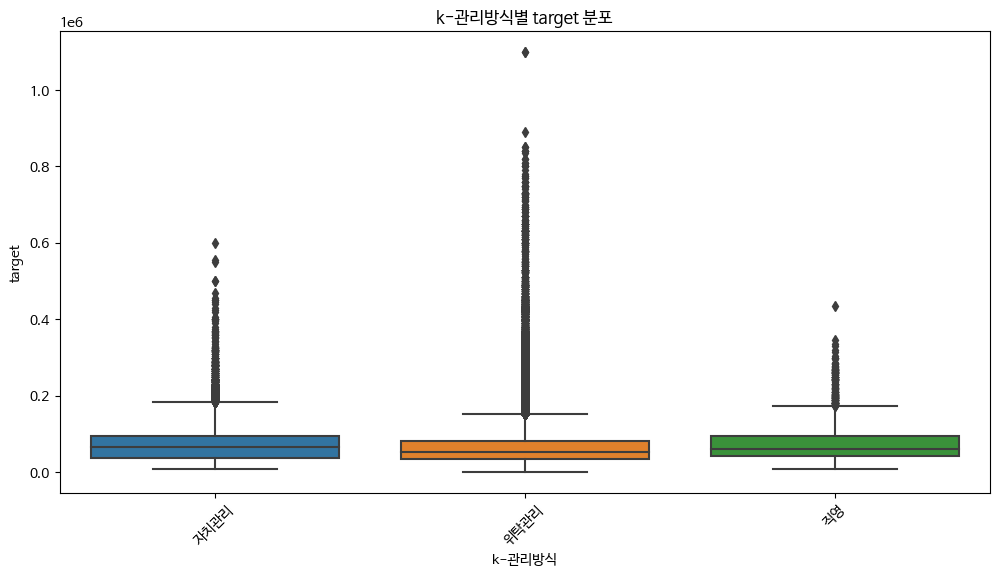

In [41]:
# k-관리방식와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='k-관리방식', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('k-관리방식별 target 분포')
plt.show()

In [42]:
method2_name = 'k-관리방식'
value_counts_method2 = concat[method2_name].value_counts()

# 결과 출력
print(value_counts_method2)

위탁관리    230361
자치관리     18144
직영        3464
Name: k-관리방식, dtype: int64


# 결측치 높고 인사이트 얻기 힘들므로 drop

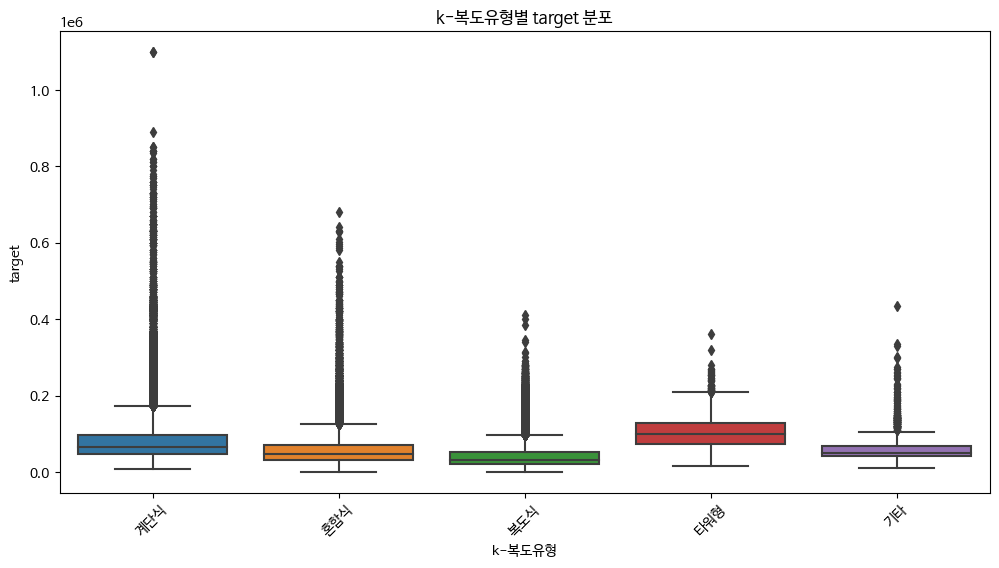

In [43]:
# k-복도유형와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='k-복도유형', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('k-복도유형별 target 분포')
plt.show()

In [44]:
type2_name = 'k-복도유형'
value_counts_type2 = concat[type2_name].value_counts()

# 결과 출력
print(value_counts_type2)

계단식    124964
혼합식     85513
복도식     38710
타워형      1371
기타       1082
Name: k-복도유형, dtype: int64


# 결측치가 많고 인사이트로 활용하기 힘들다 판단 drop

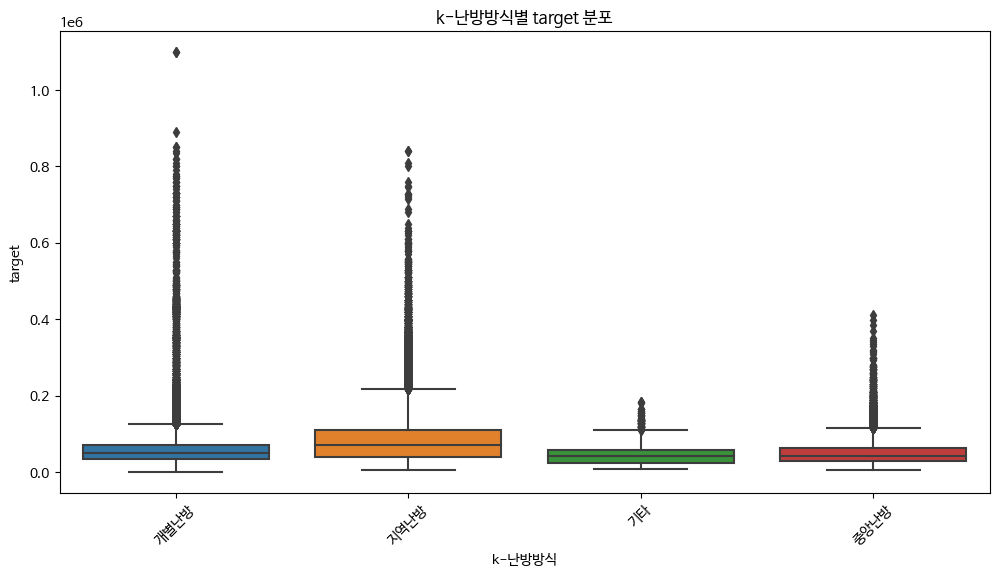

In [45]:
# k-난방방식와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='k-난방방식', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('k-난방방식별 target 분포')
plt.show()

In [46]:
method3_name = 'k-난방방식'
value_counts_method3 = concat[method3_name].value_counts()

# 결과 출력
print(value_counts_method3)

개별난방    152365
지역난방     84826
중앙난방     12687
기타        2091
Name: k-난방방식, dtype: int64


# 결측치 많고 인사이트 없음 drop

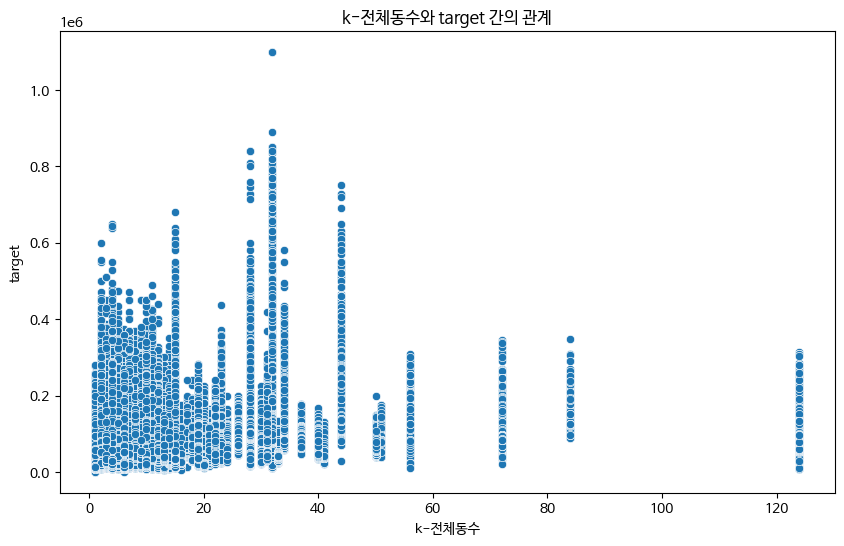

In [48]:
# k-전체동수와 target과의 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='k-전체동수', y='target', data=concat)
plt.title('k-전체동수와 target 간의 관계')
plt.show()

In [49]:
correlation_dong = concat['k-전체동수'].corr(concat['target'])
correlation_dong

0.2344701898835724

# 상관관계도 없고 이상치로 보이는 것은 특정 건물에 대한 특정으로 보고 건물별 column을 강조할 것을 고려 후 해당 column은 drop

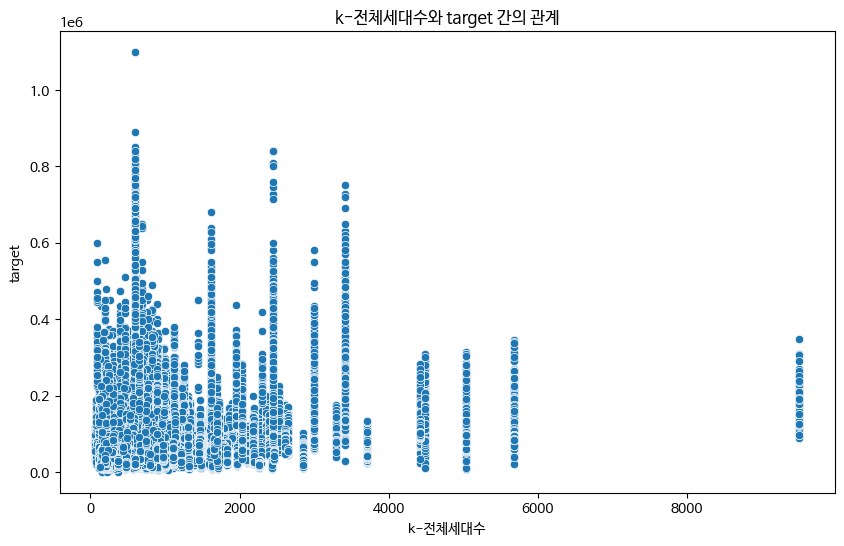

In [50]:
# k-전체세대수와 target과의 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='k-전체세대수', y='target', data=concat)
plt.title('k-전체세대수와 target 간의 관계')
plt.show()

In [51]:
correlation_dae = concat['k-전체세대수'].corr(concat['target'])
correlation_dae

0.21751234212273976

# 상관관계 없음
- drop 전에 주차대수와 합쳐 세대별 주차수 파생변수 만들기

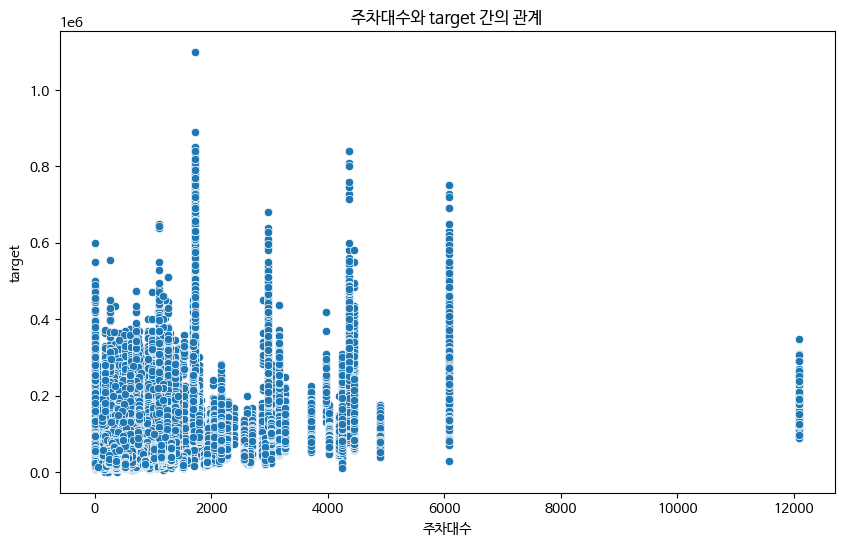

In [52]:
# 주차대수와 target과의 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='주차대수', y='target', data=concat)
plt.title('주차대수와 target 간의 관계')
plt.show()

In [53]:
correlation_jucha = concat['주차대수'].corr(concat['target'])
correlation_jucha

0.3481413861706397

In [54]:
concat['세대별_주차대수'] = concat['주차대수'] / concat['k-전체세대수']

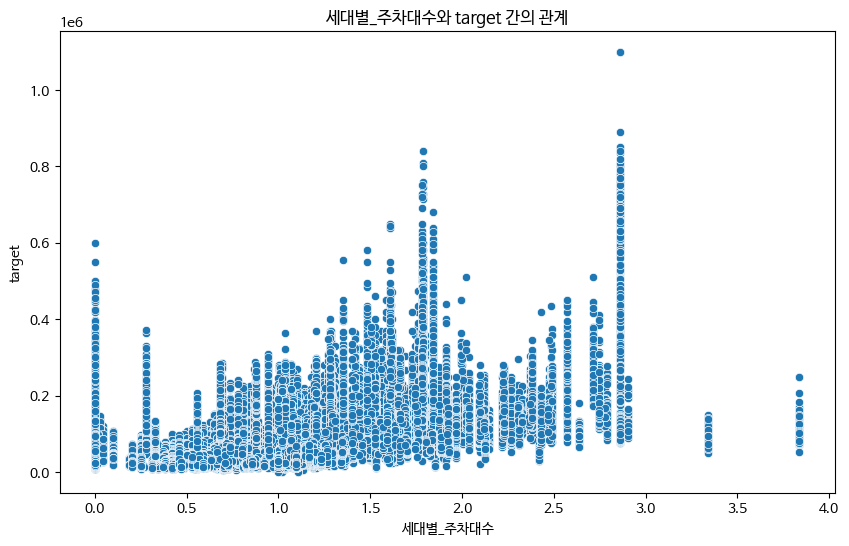

In [55]:
# 세대별_주차대수와 target과의 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='세대별_주차대수', y='target', data=concat)
plt.title('세대별_주차대수와 target 간의 관계')
plt.show()

In [57]:
correlation_jucha2 = concat['세대별_주차대수'].corr(concat['target'])
correlation_jucha2

0.3618077574727821

# 어느정도의 상관관계가 있음을 판단
- 주차 총 대수는 drop하고 세대별 주차대수는 살리기

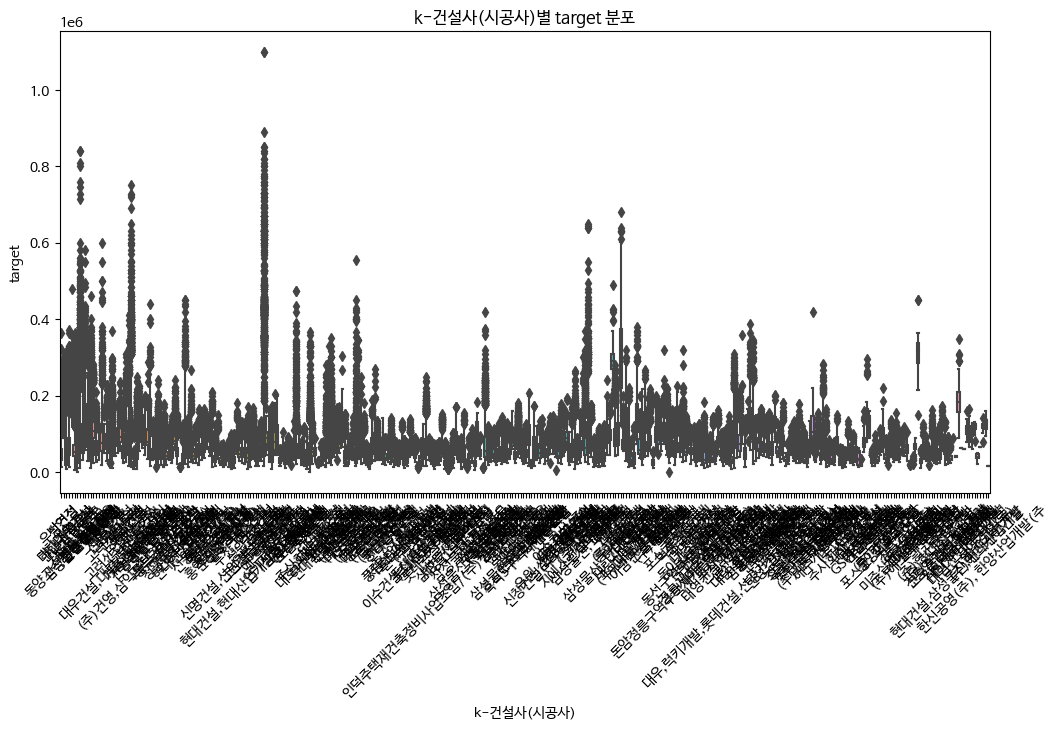

In [59]:
# k-건설사(시공사)와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='k-건설사(시공사)', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('k-건설사(시공사)별 target 분포')
plt.show()

In [58]:
who_name = 'k-건설사(시공사)'
value_counts_who = concat[who_name].value_counts()

# 결과 출력
print(value_counts_who)

삼성물산         14259
대우건설         11549
현대건설         10575
대한주택공사        7665
GS건설          7015
             ...  
두산               5
신영건설             3
자이에스앤디(주)        2
혜림건설             1
삼익건설(주)          1
Name: k-건설사(시공사), Length: 344, dtype: int64


In [63]:
total_missing_count = concat['k-건설사(시공사)'].isnull().sum()
total_missing_count

877637

# 변수별 상관관계는 있지만 결측치가 너무 많아 drop

In [64]:
total_missing_count2 = concat['k-시행사'].isnull().sum()
total_missing_count2

877834

# 변수별 상관관계는 있지만 결측치가 너무 많아 drop

# 'k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과'
- 전용면적에 다 반영된 데이터를 저해시킬 우려 - 정확한 수치가 아니라 몇채씩 있는지만 나와있기 때문
- 건물별 특징에 대한 column을 학습시킬 때 강조하고 싶으면 사용할지 고려

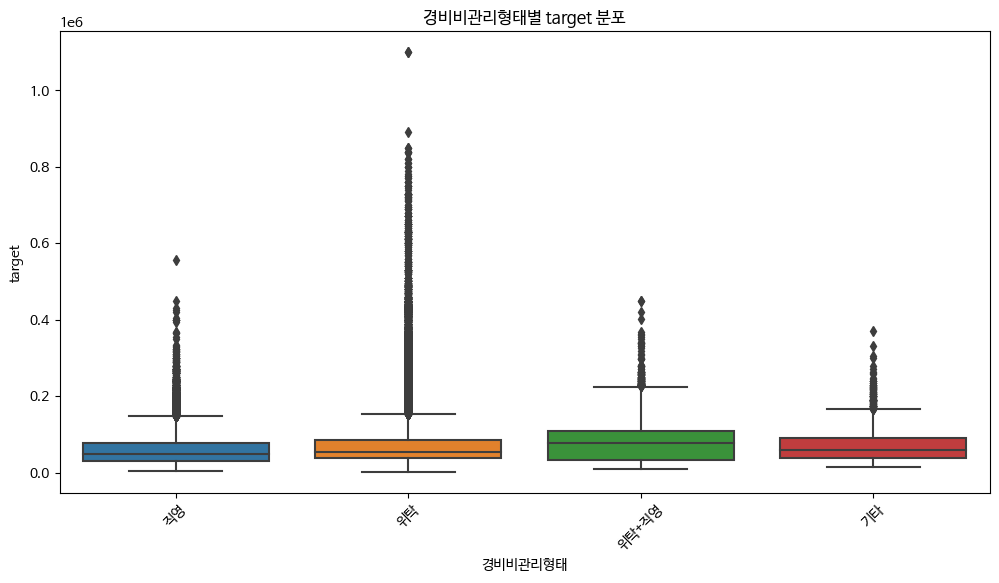

In [65]:
# 경비비관리형태와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='경비비관리형태', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('경비비관리형태별 target 분포')
plt.show()

In [67]:
total_missing_count3 = concat['경비비관리형태'].isnull().sum()
total_missing_count3

877561

# 결측치 많고 인사이트가 얻기 힘들어 drop

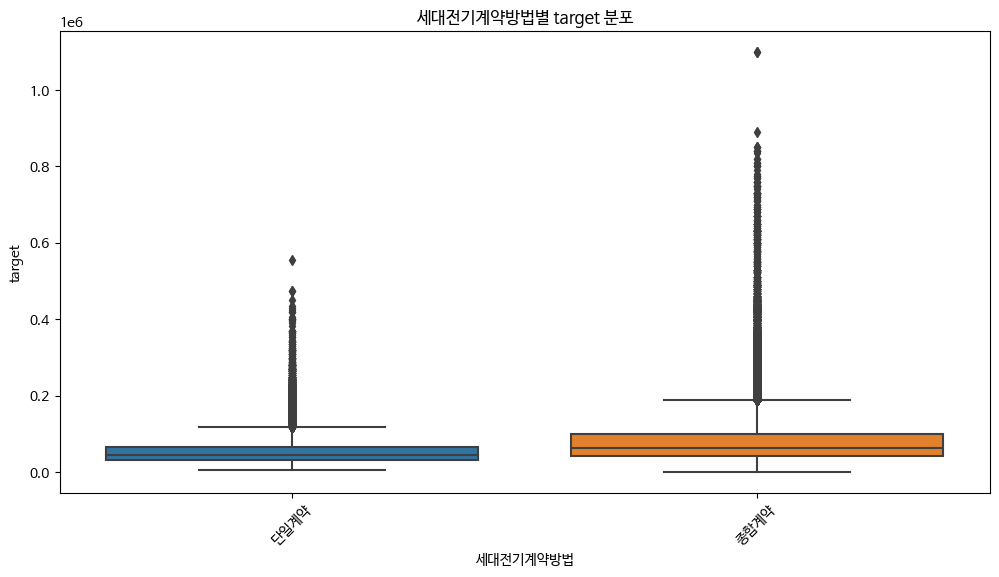

In [68]:
# 세대전기계약방법와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='세대전기계약방법', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('세대전기계약방법별 target 분포')
plt.show()

In [70]:
total_missing_count4 = concat['세대전기계약방법'].isnull().sum()
total_missing_count4

885389

# 종합계약일경우 높은 경향이 있지만 결측치가 많아 drop

In [71]:
total_missing_count5 = concat['청소비관리형태'].isnull().sum()
total_missing_count5
# 결측치 많아서 drop

877751

In [72]:
total_missing_count6 = concat['사용허가여부'].isnull().sum()
total_missing_count6
# 결측치 많아서 drop

876125

In [73]:
total_missing_count7 = concat['관리비 업로드'].isnull().sum()
total_missing_count7
# 결측치 많아서 drop

876125

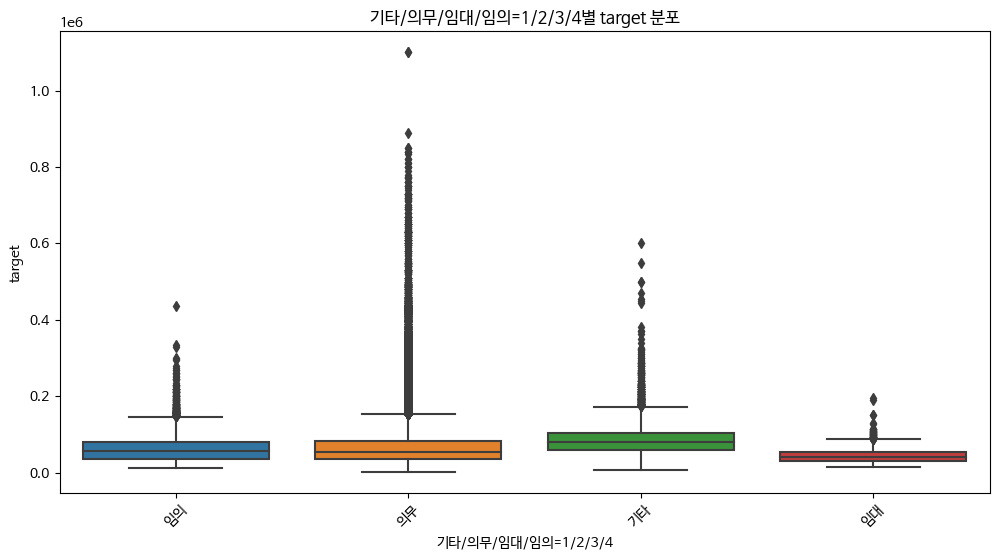

In [74]:
# 기타/의무/임대/임의=1/2/3/4와 target과의 관계 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='기타/의무/임대/임의=1/2/3/4', y='target', data=concat)
plt.xticks(rotation=45)
plt.title('기타/의무/임대/임의=1/2/3/4별 target 분포')
plt.show()

In [75]:
total_missing_count8 = concat['기타/의무/임대/임의=1/2/3/4'].isnull().sum()
total_missing_count8
# 결측치 많아서 drop

876125

In [124]:
total_missing_count9 = concat['아파트명'].isnull().sum()
total_missing_count9

2136

In [111]:
concat['등기신청일자']

0               
1               
2               
3               
4               
          ...   
9267            
9268            
9269            
9270            
9271    20230905
Name: 등기신청일자, Length: 1128094, dtype: object

등기신처일자의 null 값이 space하나로 들어가 object형으로 드러나 결측치 없는 것으로 보임

In [112]:
#등기신청일자 수정
concat['등기신청일자'] = pd.to_numeric(concat['등기신청일자'], errors='coerce').astype('Int64')
print(concat['등기신청일자'])

0           <NA>
1           <NA>
2           <NA>
3           <NA>
4           <NA>
          ...   
9267        <NA>
9268        <NA>
9269        <NA>
9270        <NA>
9271    20230905
Name: 등기신청일자, Length: 1128094, dtype: Int64


drop
- 일관성 저조
- 시군구, 번지, 본번, 부번, 계약일, 층, 단지분류, k-전체동수, k-전체세대수, 주차대수

- 결측치
- 거래유형, 분양형태, k-관리방식, k-복도유형, k-난방방식, k-건설사(시공사), k-시행사, 경비비관리형태, 세대전기계약방법, 청소비관리형태, 사용허가여부, 관리비 업로드, 기타/의무/임대/임의=1/2/3/4, k-전화번호, k-팩스번호, k-홈페이지, 단지신청일,k-등록일자, 단지소개기존clob, 단지승인일, k-사용검사일-사용승인일, k-연면적, k-주거전용면적, k-관리비부과면적, k-수정일자, 고용보험관리번호, 건축면적,좌표X,좌표Y

save
- 아파트명, 도로명, 전용면적, 계약년월, 건축년도

여부확인
- 해제사유발생일,등기신청일자

- 고려
- 단지신청일


파생변수
- 세대별_주차대수,해제사유발생여부,등기신청여부

파생변수 생성방법
- concat['세대별_주차대수'] = concat['주차대수'] / concat['k-전체세대수']
- concat['해제사유발생여부'] = pd.notnull(concat['해제사유발생일']).astype(int)
- concat['등기신청일자'] = pd.notnull(concat['등기신청일자']).astype(int)

In [117]:
concat['해제사유발생여부'] = pd.notnull(concat['해제사유발생일']).astype(int)
print(concat[['해제사유발생여부']])

      해제사유발생여부
0            0
1            0
2            0
3            0
4            0
...        ...
9267         1
9268         0
9269         0
9270         0
9271         0

[1128094 rows x 1 columns]


In [118]:
count_release_occurred = concat['해제사유발생여부'].value_counts().get(1, 0)
count_release_occurred

6195

In [123]:
concat['등기신청일자여부'] = pd.notnull(concat['등기신청일자']).astype(int)
print(concat[['등기신청일자여부']])

      등기신청여부
0          1
1          1
2          1
3          1
4          1
...      ...
9267       1
9268       1
9269       1
9270       1
9271       1

[1128094 rows x 1 columns]


In [120]:
count_release_occurred2 = concat['등기신청일자'].value_counts().get(1, 0)
count_release_occurred2

16823

drop
- 일관성 저조
- 시군구, 번지, 본번, 부번, 계약일, 층, 단지분류, k-전체동수, k-전체세대수, 주차대수

- 결측치
- 거래유형, 분양형태, k-관리방식, k-복도유형, k-난방방식, k-건설사(시공사), k-시행사, 경비비관리형태, 세대전기계약방법, 청소비관리형태, 사용허가여부, 관리비 업로드, 기타/의무/임대/임의=1/2/3/4, k-전화번호, k-팩스번호, k-홈페이지, 단지신청일,k-등록일자, 단지소개기존clob, 단지승인일, k-사용검사일-사용승인일, k-연면적, k-주거전용면적, k-관리비부과면적, k-수정일자, 고용보험관리번호, 건축면적,좌표X,좌표Y

save
- 아파트명, 도로명, 전용면적, 계약년월, 건축년도

여부확인
- 해제사유발생일,등기신청일자

- 고려
- 단지신청일


파생변수
- 세대별_주차대수(결측치 다수로 drop),해제사유발생여부,등기신청여부

파생변수 생성방법
- concat['세대별_주차대수'] = concat['주차대수'] / concat['k-전체세대수']
- concat['해제사유발생여부'] = pd.notnull(concat['해제사유발생일']).astype(int)
- concat['등기신청일자'] = pd.notnull(concat['등기신청일자']).astype(int)

최종선택 column
- 아파트명, 도로명, 전용면적, 계약년월, 건축년도
제거 고민 기준
- 해제사유발생여부, 등기신청여부, 이상치(전용면적 제외 이상치 없음)
- 시각적으로 보았을 때 전용면적과 target사이의 이상치는 크게 영향을 미치지 않을 것으로 판단되어 이상치 제거는 하지 않는 것이 좋아보임